# Pipeline for BIAPT lab EEG Preprocessing: 
#### inspired by: https://github.com/hoechenberger/pybrain_mne/
#### adapted by: Charlotte Maschke
#### This pipeline uses MNE Python to preprocess EEG data: Plese go here: 
####                                https://mne.tools/stable/overview/index.html
####  for more documentation on MNE Python

## Some setup and import

In [1]:
import matplotlib
#import mne_bids
import pathlib
import mne
import os
import os.path as op
from mne import viz

# interactive plotting functions.


from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
#import openneuro

#from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Ensure Matplotlib uses the Qt5Agg backend, 
# which is the best choice for MNE-Python's 
# interactive plotting functions.
matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt

### Which subject do you want to preprocess? 

In [2]:
ID = "001"
session = "01"
task = "post120"

In [3]:
raw_path = "./Data/pilot_tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_eeg.mff".format(ID,session,ID,session,task)
raw_path

'./Data/pilot_tacs/sub-001/ses-01/eeg/sub-001_ses-01_task-post120_eeg.set'

## Load the raw data!

In [4]:
raw = mne.io.read_raw_egi(raw_path)
raw

Reading c:\Users\VivoBook\Documents\GitHub\GitHub_remote_version\Data\pilot_tacs\sub-001\ses-01\eeg\sub-001_ses-01_task-post120_eeg.fdt


C:\Users\VivoBook\AppData\Local\Temp\ipykernel_11964\4284376005.py:1: RuntimeWarning: Data file name in EEG.data (sub-TACS01_ses-01_task-post120_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-001_ses-01_task-post120_eeg.fdt).
  raw = mne.io.read_raw_eeglab(raw_path)


<RawEEGLAB | sub-001_ses-01_task-post120_eeg.fdt, 129 x 335935 (335.9 s), ~172 kB, data not loaded>

## Resample the data to 250

In [5]:
if raw.info['sfreq'] != 250:
    raw = raw.resample(250)

### Keep only the EEG

In [6]:
# this is to load EEG. If you want to load other stuff please refer to the website documetation
eeg = raw.pick_types(eeg = True)
print('Number of channels in EEG:')
len(eeg.ch_names)

Number of channels in EEG:


129

## Crop the data

Depending on the data, we may need to crop the begining or/and the end

In [ ]:
eeg.plot(duration=30, title='raw')

In [ ]:
eeg_cropped= eeg.crop(tmin=2.0)
#eeg_cropped.plot(duration=30, title='cropped')

## Filter the data

In [7]:
# load actual data into system (before it was only metadata)
#eeg_cropped.load_data()
eeg.load_data()

# filter the data between 1 to 55 Hz
#eeg_cropped_filtered = eeg_cropped.filter(l_freq=1, h_freq = 55)
eeg_filtered = eeg.filter(l_freq=1, h_freq = 55) 

# notch filter the data for freq =60
#eeg_notch = eeg_cropped_filtered.copy().notch_filter(freqs=60)
eeg_notch = eeg_filtered.notch_filter(freqs=60)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 825 samples (3.300 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 

In [8]:
%matplotlib qt
viz.plot_raw_psd(eeg_notch, exclude = ['E129'], fmax = 70)
plt.savefig('./out_figures/pilot-tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_raw_filtered.png'.format(ID,session,task,ID,session,task))

Effective window size : 8.192 (s)


## Visualize raw data to identify bad channels

Using matplotlib as 2D backend.


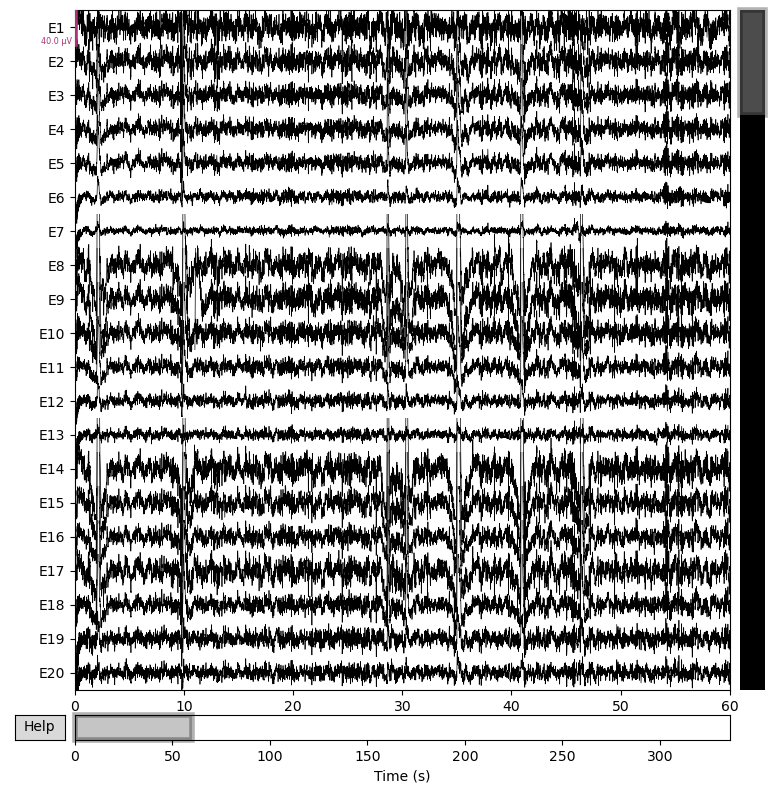

Channels marked as bad: ['E11', 'E27', 'E64', 'E68', 'E69', 'E88', 'E94', 'E114', 'E126']


In [9]:
#eeg_notch.plot()
#eeg_filtered.plot(n_channels=30, duration=30)
eeg_notch.plot(n_channels=20, duration=60)

Verify if labelled correctly

In [10]:
marked_bad = eeg_notch.info['bads']
marked_bad

['E11', 'E27', 'E64', 'E68', 'E69', 'E88', 'E94', 'E114', 'E126']

In [11]:
# save in a txt
with open('./eeg_output/pilot-tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_marked_bads.json'.format(ID,session,ID,session,task), 'w') as outfile:
    outfile.write("\n".join(marked_bad))



# Interpolate bad channels

In [12]:
eeg_interpol = eeg_notch.interpolate_bads()

Interpolating bad channels
    Automatic origin fit: head of radius 9924.7 mm
Computing interpolation matrix from 120 sensor positions
Interpolating 9 sensors


C:\Users\VivoBook\AppData\Local\Temp\ipykernel_11964\3839503059.py:1: RuntimeWarning: Estimated head size (9924.7 mm) exceeded 99th percentile for adult head size
  eeg_interpol = eeg_notch.interpolate_bads()
C:\Users\VivoBook\AppData\Local\Temp\ipykernel_11964\3839503059.py:1: RuntimeWarning: (X, Y) fit (-0.0, -59.3) more than 20 mm from head frame origin
  eeg_interpol = eeg_notch.interpolate_bads()


## Average Reference the data

In [13]:
# use the average of all channels as reference
eeg_avg_ref = eeg_interpol.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [ ]:
eeg_avg_ref.plot(duration=30)

In [14]:
%matplotlib tk
viz.plot_raw_psd(eeg_avg_ref, fmax = 70)
plt.savefig('./out_figures/pilot-tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_avg_ref.png'.format(ID,session,task,ID,session,task))

Effective window size : 8.192 (s)


In [ ]:
print(eeg_avg_ref.info)

# RUN ICA

## Manual selection of ICA components

In [ ]:
# pick some channels that clearly show heartbeats and blinks
#eog_channels = ['E8', 'E12','E14','E21', 'E25', 'E126', 'E127']

In [15]:
#eeg_avg_ref.info['EOG channels']
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

ica = ICA(n_components=15, max_iter='auto', random_state=97)
ica.fit(eeg_avg_ref)

Fitting ICA to data using 129 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 4.7s.


Method,fastica
Fit,36 iterations on raw data (83984 samples)
ICA components,15
Explained variance,100.0 %
Available PCA components,129
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=15, n_times=83984
    Range : 0 ... 83983 =      0.000 ...   335.932 secs
Ready.


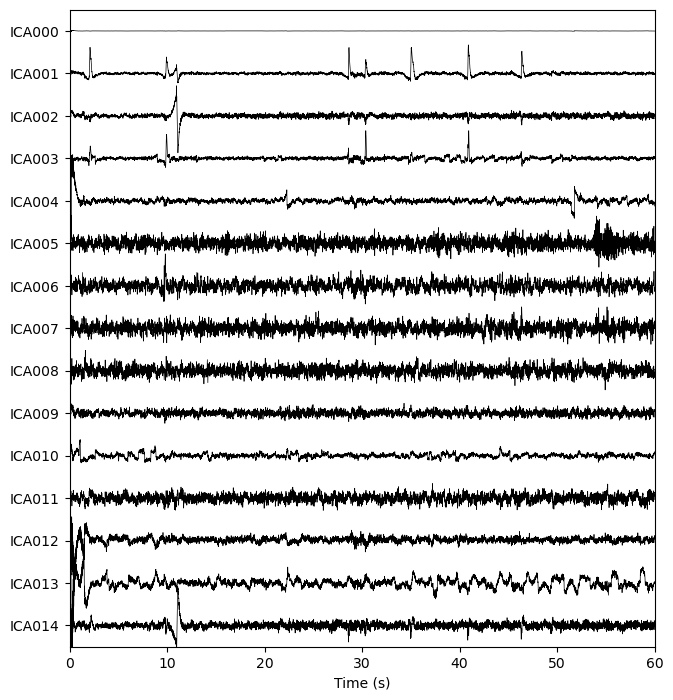

In [16]:
ica.plot_sources(eeg_avg_ref, show_scrollbars=False, stop = 60)


In [17]:
ica.plot_components()

[<MNEFigure size 975x731 with 15 Axes>]

In [18]:
ica

Method,fastica
Fit,36 iterations on raw data (83984 samples)
ICA components,15
Explained variance,100.0 %
Available PCA components,129
Channel types,eeg
ICA components marked for exclusion,ICA001ICA002


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 129 PCA components


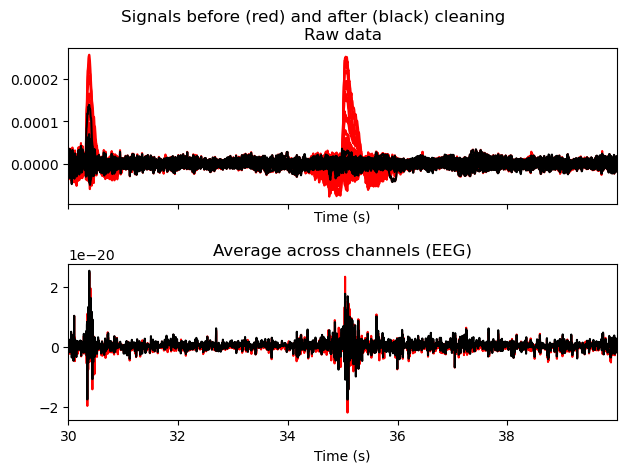

In [19]:
# blinks
ica.plot_overlay(eeg_avg_ref, start = 30*250, stop = 40*250)
#ica.plot_overlay(eeg_avg_ref, exclude=[0,1,2,3],start = 30*250, stop = 40*250)

Double check which component to remove: 

In [20]:
ica.exclude

[1, 2]

Remove component definetely

In [21]:
eeg_postica = eeg_avg_ref.copy()
ica.apply(eeg_postica)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 129 PCA components


<RawEEGLAB | sub-001_ses-01_task-post120_eeg.fdt, 129 x 83984 (335.9 s), ~82.8 MB, data loaded>

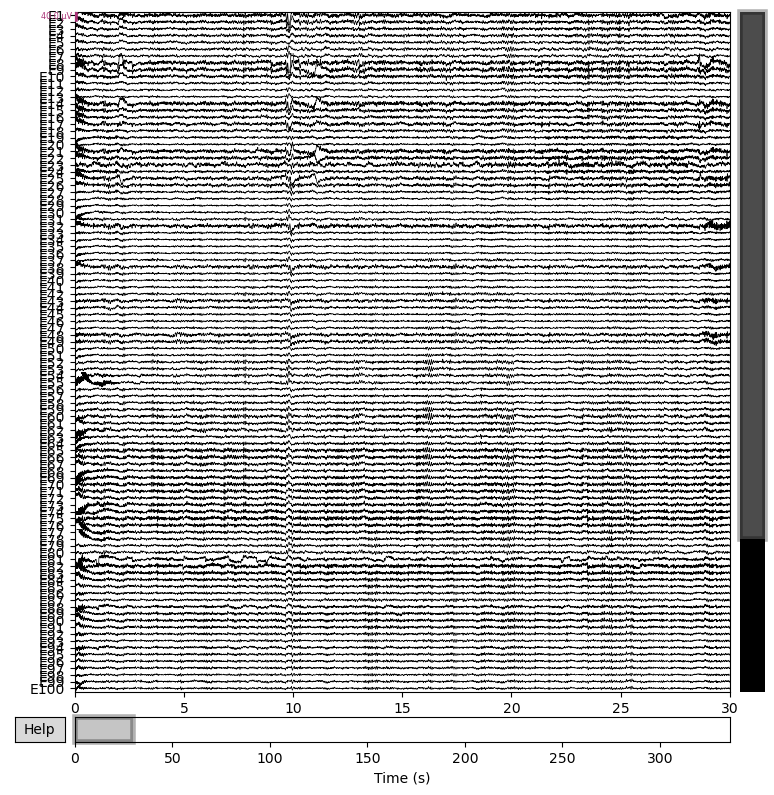

Channels marked as bad: none
Channels marked as bad: none


In [22]:
# PLot to compare both signals pre and post ICA
eeg_avg_ref.plot(title='raw', n_channels= 100, duration =30)
eeg_postica.plot(title='ICA correction', n_channels= 100, duration =30)

## Remove Non-Brain Electrodes and bad channels 

In [23]:
non_brain_el = ['E127', 'E126', 'E17', 'E21', 'E14', 'E25', 'E8', 'E128', 'E125', 'E43', 'E120', 'E48', 
                'E119', 'E49', 'E113', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107' ]

#only add non-brain channels if not already part of noisy channels
for e in non_brain_el: 
    if e not in eeg_avg_ref.info['bads']:
        eeg_postica.info['bads'].append(e)


In [ ]:
print(eeg_postica.info['bads'])

In [24]:
# remove channels marked as bad and non-brain channels
eeg_brainonly = eeg_postica.copy().drop_channels(eeg_postica.info['bads'])
eeg_brainonly

<RawEEGLAB | sub-001_ses-01_task-post120_eeg.fdt, 105 x 83984 (335.9 s), ~67.4 MB, data loaded>

In [ ]:
eeg_brainonly.plot(title='brain only', duration=10)

## Save final non brain data

In [ ]:
#out_dir = pathlib.Path("./Results/sub-{}/ses-{}/eeg/".format(ID,session))

#if not os.path.exists(out_dir):
    #os.makedirs(out_dir)
    
#out_path = pathlib.Path(out_dir, "sub-{}_ses-{}_task-{}.set".format(ID,session,task))

In [25]:
eeg_brainonly.save("./eeg_output/pilot-tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'nonbrainfiltered'), overwrite=True)
#ici changer pour le sauver dans derivatives, dossier clean (avec un readme expliquant le cleaning) et le fichier sous le bids format

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Writing c:\Users\VivoBook\Documents\GitHub\GitHub_remote_version\eeg_output\pilot-tacs\sub-001\ses-01\eeg\sub-001_ses-01_task-post120_nonbrainfiltered_eeg.fif
Closing c:\Users\VivoBook\Documents\GitHub\GitHub_remote_version\eeg_output\pilot-tacs\sub-001\ses-01\eeg\sub-001_ses-01_task-post120_nonbrainfiltered_eeg.fif
[done]


# Make epochs of 10 s

In [26]:
epochs = mne.make_fixed_length_epochs(eeg_brainonly, duration = 10, overlap=0)

Not setting metadata
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated


Loading data for 33 events and 2500 original time points ...
0 bad epochs dropped
Loading data for 33 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...


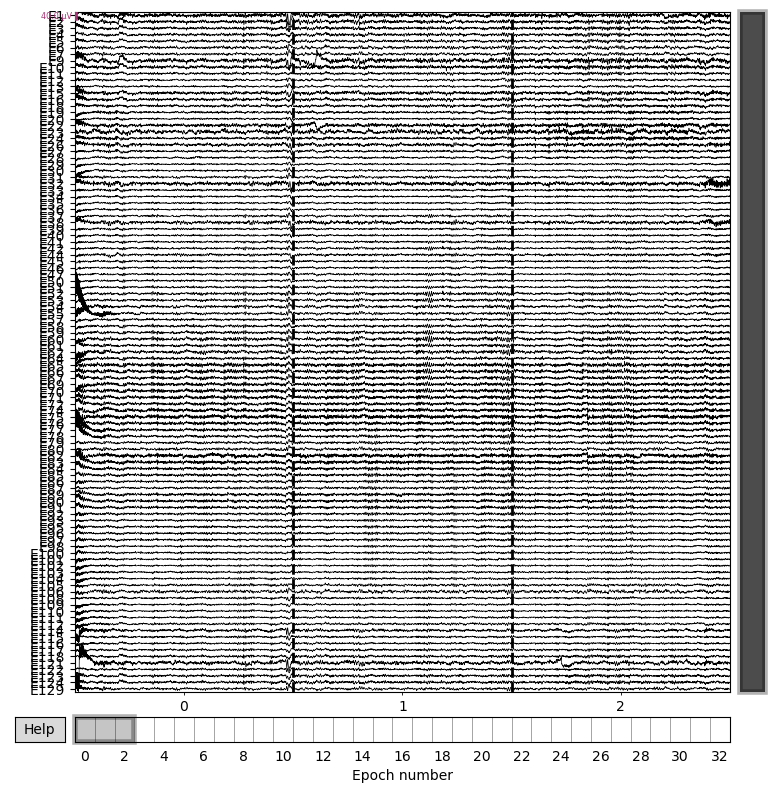

C:\Users\VivoBook\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:1779: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _cols = np.array([self.mne.epoch_color_bad,


Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 original time points ...
Loading data for 3 events and 2500 origi

In [27]:
epochs.plot(n_epochs=3, n_channels=105, scalings=20e-6)

In [28]:

epochs.drop_bad()  #double check on this


In [29]:
epochs

Number of events,32
Events,1: 32
Time range,0.000 – 9.996 sec
Baseline,off


In [30]:
epochs.save(("./eeg_output/pilot-tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'epoch')),overwrite=True)


Overwriting existing file.
Loading data for 1 events and 2500 original time points ...
Loading data for 32 events and 2500 original time points ...


C:\Users\VivoBook\AppData\Local\Temp\ipykernel_11964\4051504176.py:1: RuntimeWarning: This filename (./eeg_output/pilot-tacs/sub-001/ses-01/eeg/sub-001_ses-01_task-post120_epoch_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(("./eeg_output/pilot-tacs/sub-{}/ses-{}/eeg/sub-{}_ses-{}_task-{}_{}_eeg.fif".format(ID, session, ID, session, task, 'epoch')),overwrite=True)
